In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from string import punctuation
print(punctuation)
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [2]:
df = pd.read_csv("SET_processed_latest_version.csv")
for i in range(df.shape[1]):
    df.iloc[:,i]= df.iloc[:,i].replace([555, 777,888,999,'555','777','888','999' ], np.nan)
text=df.loc[:,['GRYD_ETO_ID','S6b_Other_Activities','S11a_Comments','A1_Description','A2_Description','A3_Description','O1_other_group_name','Group_name_part1','PUSH_1','PULL_1']]
text["text_all"] = text.apply(lambda x: ','.join(x.dropna()), axis=1)

In [3]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
from nltk.corpus import stopwords
sw = stopwords.words('english')

def  normalize (df):
    contents=df.dropna().values
    

    
    
    for i in range (contents.shape[0]):
        contents[i]=contents[i].replace(",", " ")
        
    all_contents = [''.join([c for c in i if c not in punctuation]) for i in contents]
    all_contents = [i.lower() for i in all_contents]
    all_contents= [i.split() for i in all_contents]
    
    for i in range (len(all_contents)):
        all_contents[i]=remove_noise(all_contents[i],sw)
    
    
    clean_tokens = [[] for _ in range(len(all_contents))]
    other_trash = ['im','a','u','2','wont','thats','dont', 'cant', 'didnt','isnt','ive','doesnt']
    trash_tokens = sw + other_trash
    for i in range(len(all_contents)):
        for token in all_contents[i]:
            if token not in trash_tokens:
                clean_tokens[i].append(token)
       
    

    
    return clean_tokens

In [4]:
original = normalize(text['S11a_Comments'])

In [5]:
df1=pd.read_csv('unified_data_train.csv')

In [6]:
df2=pd.read_csv('unified_data_test.csv')

In [7]:
df=pd.concat([df1, df2], ignore_index=True)

In [8]:
df=df.rename(columns={'Emotion':'sentiment','Text':'selected_text'})

In [9]:
print(df.sentiment.value_counts())

neutral    104338
joy         39299
sadness     17951
fear        17827
anger       11480
Name: sentiment, dtype: int64


In [10]:
fear = normalize(df.loc[df['sentiment']=='fear']['selected_text'])
sadness = normalize(df.loc[df['sentiment']=='sadness']['selected_text'])
neutral = normalize(df.loc[df['sentiment']=='neutral']['selected_text'])
joy = normalize(df.loc[df['sentiment']=='joy']['selected_text'])


anger = normalize(df.loc[df['sentiment']=='anger']['selected_text'])

In [11]:
def get_tweets_for_model(cleaned_tokens_list):
    
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

fear_new = get_tweets_for_model(fear)
sadness_new = get_tweets_for_model(sadness)
neutral_new = get_tweets_for_model(neutral)
joy_new = get_tweets_for_model(joy)


anger_new = get_tweets_for_model(anger)

import random
fear_data = [(i, "fear")for i in fear_new]
sadness_data = [(i, "sadness")for i in sadness_new]
neutral_data = [(i, "neutral")for i in neutral_new]
joy_data = [(i, "joy")for i in joy_new]


anger_data = [(i, "anger")for i in anger_new]
dataset = fear_data+ sadness_data +neutral_data+joy_data+anger_data

len(dataset)


190895

In [14]:
random.shuffle(dataset)

train_data = dataset[:150000]
test_data = dataset[15000:]


from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier1, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.6835327894482504
Most Informative Features
                      rt = True           sadnes : neutra =   1699.6 : 1.0
                feminist = True            anger : neutra =    934.7 : 1.0
                   trump = True           sadnes : neutra =    587.1 : 1.0
                 sadness = True           sadnes : neutra =    433.1 : 1.0
                   anger = True            anger : neutra =    422.5 : 1.0
                    rage = True            anger : neutra =    353.9 : 1.0
              republican = True            anger : neutra =    335.8 : 1.0
                    fuck = True            anger : neutra =    330.2 : 1.0
              depression = True           sadnes : neutra =    298.3 : 1.0
                    tcot = True            anger : neutra =    295.8 : 1.0
None


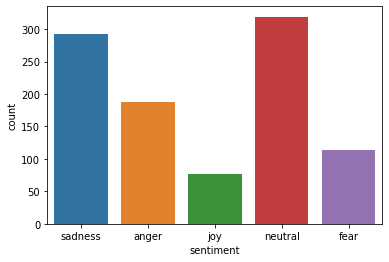

In [15]:
sentiment=list()
for i in range (len(original)):
    sentiment.append(classifier.classify(dict([token, True] for token in original[i])))
    
text['sentiment']=np.nan
temp=0
for i in range (text.shape[0]):
    if (type(text.loc[i,'S11a_Comments'])==str):
        text.loc[i,'sentiment']=sentiment[temp]
        temp=temp+1
sns.countplot(text['sentiment'])

In [16]:
text.head()

,GRYD_ETO_ID,S6b_Other_Activities,S11a_Comments,A1_Description,A2_Description,A3_Description,O1_other_group_name,Group_name_part1,PUSH_1,PULL_1,text_all,sentiment
0,BVCB-0-144-1,"Working out, CBT, boxing","School. Poor grades, car accident, not enough ...",School,NaN,School,Other group,Group,Somebody got out of jail that brought a lot of...,School. work. moving,"BVCB-0-144-1,Working out, CBT, boxing,School. ...",sadness
1,BVCB-0-174-1,Basketball,Mother died,Basketball,NaN,NaN,No name,Money Gang,NaN,NaN,"BVCB-0-174-1,Basketball,Mother died,Basketball...",sadness
2,Southeast 3-10-24-1,Extra activities with children,Favor cousin was murder and never found his ki...,"Church, job and school",Church choir and praise team,NaN,Church group,No group,NaN,NaN,"Southeast 3-10-24-1,Extra activities with chil...",anger
3,Southeast 3-10-18-1,Actor/dance,Best friend brother was murder [sic] by 16 and...,"Church, school and job",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-18-1,Actor/dance,Best friend br...",sadness
4,Southeast 3-10-17-1,Singing,Best fried brother was murder [sic] by 18yr boy,"Church, job, and school",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-17-1,Singing,Best fried brother...",anger


In [17]:
score=pd.read_csv('full_embeddedness.csv')
score.head()

,ID,admin,age,sex,zone,gang,family,other,risk
0,BVCB-0-144-1,3,20.0,2,22.0,-7.812395,-3.665696,0.127677,-5.196776
1,BVCB-0-174-1,2,21.0,1,22.0,2.103629,-1.267477,2.417171,9.762419
2,Southeast 3-10-24-1,1,NaN,2,21.0,NaN,6.626468,-0.225167,-2.651080
3,Southeast 3-10-18-1,1,25.0,1,21.0,-8.583601,6.626468,-0.225167,-2.073084
4,Southeast 3-10-17-1,1,24.0,2,21.0,-8.583601,6.626468,1.413228,-1.421399


In [18]:
risk=score.loc[:,['ID','gang']]

In [19]:
emotion=text.loc[:,['GRYD_ETO_ID','sentiment']]
emotion=emotion.rename(columns={'GRYD_ETO_ID':'ID'})

In [20]:
merged_inner = pd.merge(left=emotion, right=risk, on='ID', how='inner')

In [21]:
df=merged_inner.dropna()

In [22]:
df.head()

,ID,sentiment,gang
0,BVCB-0-144-1,sadness,-7.812395
1,BVCB-0-174-1,sadness,2.103629
2,BVCB-0-174-1,sadness,2.931780
6,Southeast 3-10-18-1,sadness,-8.583601
7,Southeast 3-10-17-1,anger,-8.583601


Text(0, 0.5, 'gang_score')

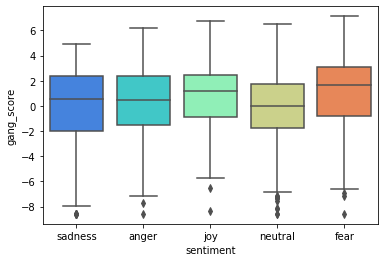

In [23]:
sns.boxplot(x='sentiment',y='gang',data=df,palette='rainbow')
plt.ylabel('gang_score')